In [6]:
# Stock Price Prediction Demo
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('dark_background')
sns.set_palette("husl")

print("✅ All packages imported successfully!")

✅ All packages imported successfully!


In [19]:
def get_stock_data(symbol, period="1y", interval="1d"):
    """Fetch stock data using yahooquery"""
    ticker = Ticker(symbol)
    df = ticker.history(period=period, interval=interval)
    
    if df is None or df.empty:
        raise ValueError(f"No data returned for {symbol}")
    
    # Handle MultiIndex if present
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index(level=0, drop=True)
    df = df.reset_index()
    
    # Capitalize column names to match expected format
    df.columns = [col.capitalize() for col in df.columns]
    
    # Fix: Handle timezone-aware/naive datetime mixing
    date_col = 'Datetime' if 'Datetime' in df.columns else 'Date'
    
    # Convert to datetime and remove timezone info (normalize to naive)
    df[date_col] = pd.to_datetime(df[date_col], utc=True).dt.tz_localize(None)
    
    # Rename to 'Date' for consistency
    if date_col == 'Datetime':
        df = df.rename(columns={'Datetime': 'Date'})
    
    return df

In [20]:
def train_linear_regression(series, lag=20):
    """Train linear regression model for price prediction"""
    values = series.astype(float).values
    
    if len(values) <= lag + 1:
        raise ValueError("Not enough data to train model")
    
    # Create training data with sliding window
    X, y = [], []
    for i in range(lag, len(values)):
        X.append(values[i - lag : i])
        y.append(values[i])
    
    X_arr = np.array(X)
    y_arr = np.array(y)
    
    # Train model
    model = LinearRegression()
    model.fit(X_arr, y_arr)
    
    # Calculate confidence (R²)
    r2 = max(0.0, min(1.0, model.score(X_arr, y_arr)))
    
    return model, r2

def predict_future_prices(model, last_window, horizon=5):
    """Predict future prices using recursive approach"""
    window = last_window.copy()
    predictions = []
    
    for _ in range(horizon):
        pred = model.predict(window.reshape(1, -1))[0]
        predictions.append(pred)
        # Update window: remove oldest, add prediction
        window = np.append(window[1:], pred)
    
    return predictions

print("✅ Prediction functions defined!")

✅ Prediction functions defined!


In [21]:
def plot_price_prediction(data, predictions, symbol, confidence):
    """Create comprehensive price prediction visualization"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Price Chart with Predictions
    ax1.plot(data['Date'], data['Close'], label='Historical Price', linewidth=2, color='white')
    
    # Add prediction points
    last_date = data['Date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(predictions), freq='D')
    ax1.plot(future_dates, predictions, 'o-', label='Predictions', linewidth=2, color='cyan', markersize=6)
    
    ax1.set_title(f'{symbol} Price Prediction (Confidence: {confidence:.1%})', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Highlight recent data
    recent_data = data.tail(30)
    ax1.plot(recent_data['Date'], recent_data['Close'], linewidth=3, color='yellow', alpha=0.7)
    
    # Plot 2: Prediction Confidence and Details
    ax2.bar(range(1, len(predictions) + 1), predictions, 
            color=['lightgreen' if p > data['Close'].iloc[-1] else 'lightcoral' for p in predictions],
            alpha=0.7)
    ax2.axhline(y=data['Close'].iloc[-1], color='white', linestyle='--', linewidth=2, label='Current Price')
    ax2.set_title('Future Price Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Days Ahead', fontsize=12)
    ax2.set_ylabel('Predicted Price ($)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions defined!")

✅ Visualization functions defined!


🚀 Stock Price Prediction Demo for AAPL
📊 Fetching historical data...
✅ Retrieved 251 data points
📅 Date range: 2024-10-28 to 2025-10-28

🤖 Training Linear Regression model (lag=20)...
✅ Model trained with 95.5% confidence

🔮 Making 5-day predictions...
💰 Current Price: $268.40
🎯 Next Day Prediction: $266.80
📈 Expected Change: -0.60%
📊 Signal: SELL

📊 Creating visualizations...


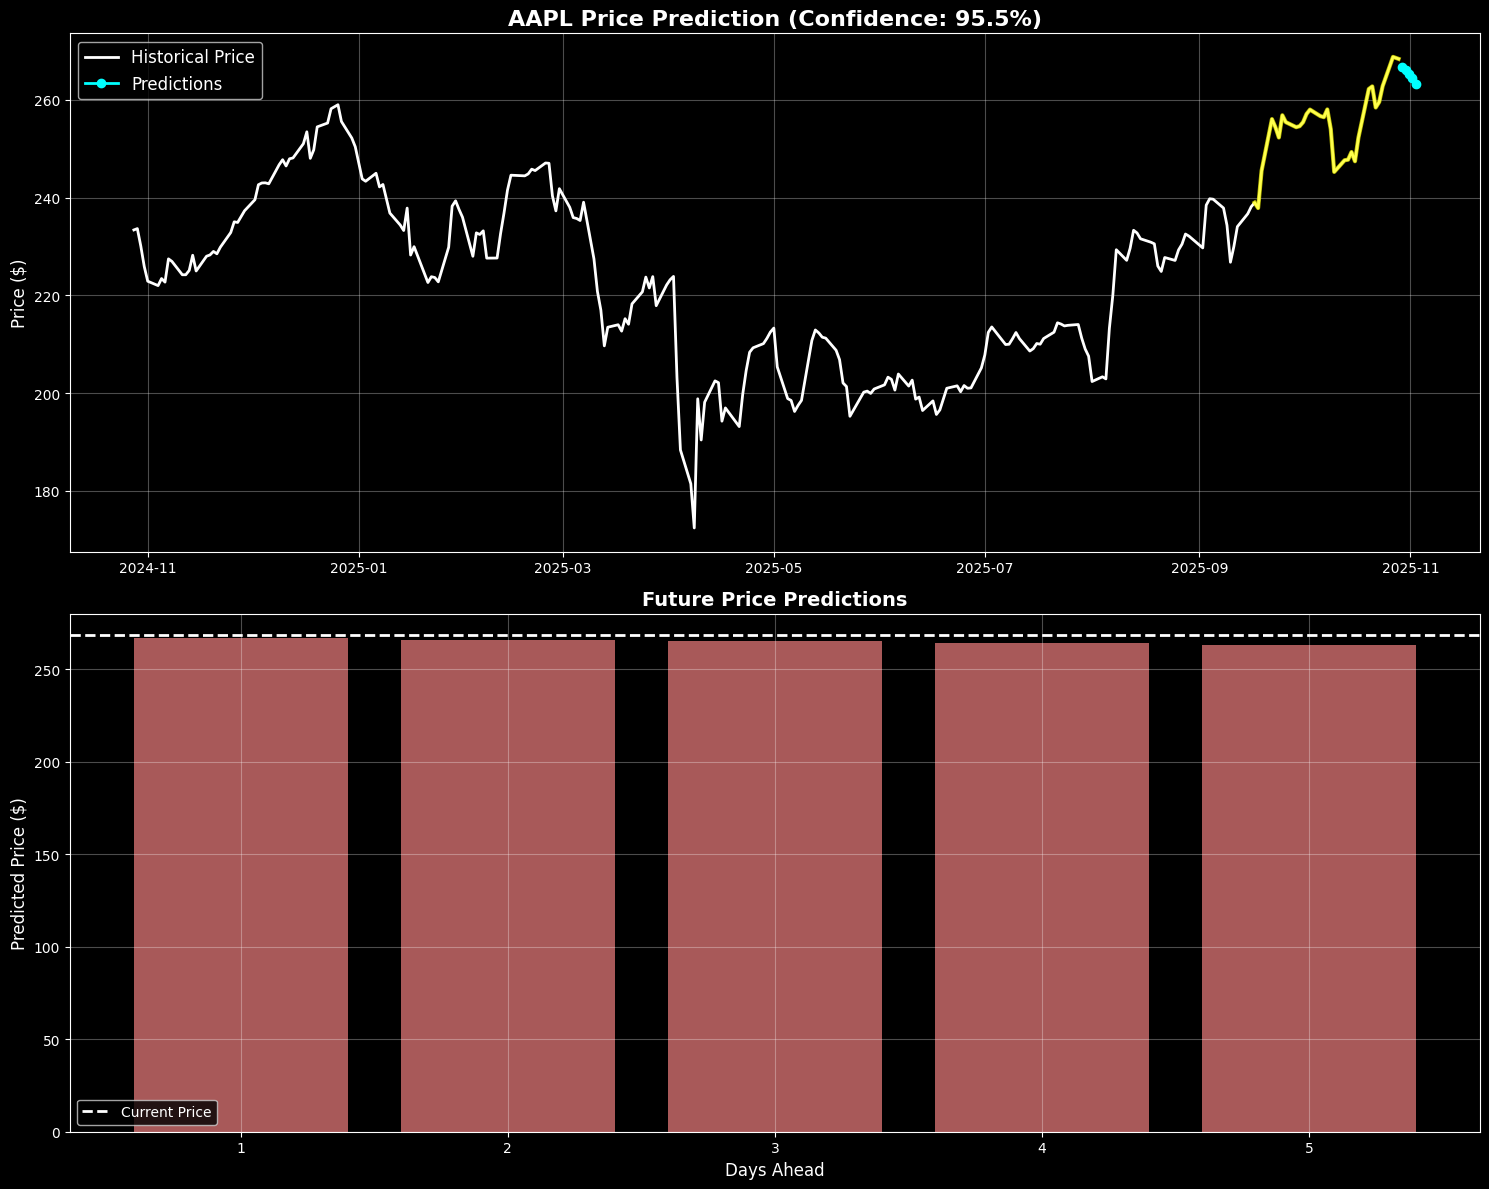


📋 Detailed Predictions:
   Day 1: $266.80 (-0.60%)
   Day 2: $266.06 (-0.87%)
   Day 3: $265.32 (-1.15%)
   Day 4: $264.42 (-1.48%)
   Day 5: $263.25 (-1.92%)


In [22]:
# Main demonstration
def run_prediction_demo(symbol="AAPL", lag=20, horizon=5):
    print(f"🚀 Stock Price Prediction Demo for {symbol}")
    print("=" * 50)
    
    # 1. Get data
    print("📊 Fetching historical data...")
    data = get_stock_data(symbol)
    if data is None:
        return
    
    print(f"✅ Retrieved {len(data)} data points")
    print(f"📅 Date range: {data['Date'].min().strftime('%Y-%m-%d')} to {data['Date'].max().strftime('%Y-%m-%d')}")
    
    # 2. Train model
    print(f"\n🤖 Training Linear Regression model (lag={lag})...")
    model, confidence = train_linear_regression(data['Close'], lag=lag)
    print(f"✅ Model trained with {confidence:.1%} confidence")
    
    # 3. Make predictions
    print(f"\n🔮 Making {horizon}-day predictions...")
    last_window = data['Close'].tail(lag).values.astype(float)
    predictions = predict_future_prices(model, last_window, horizon)
    
    current_price = data['Close'].iloc[-1]
    next_day_pred = predictions[0]
    change_pct = ((next_day_pred - current_price) / current_price) * 100
    
    print(f"💰 Current Price: ${current_price:.2f}")
    print(f"🎯 Next Day Prediction: ${next_day_pred:.2f}")
    print(f"📈 Expected Change: {change_pct:+.2f}%")
    print(f"📊 Signal: {'BUY' if next_day_pred > current_price else 'SELL' if next_day_pred < current_price else 'HOLD'}")
    
    # 4. Visualizations
    print(f"\n📊 Creating visualizations...")
    plot_price_prediction(data, predictions, symbol, confidence)
    
    # 5. Show prediction details
    print(f"\n📋 Detailed Predictions:")
    for i, pred in enumerate(predictions, 1):
        change = ((pred - current_price) / current_price) * 100
        print(f"   Day {i}: ${pred:.2f} ({change:+.2f}%)")
    
    return {
        'symbol': symbol,
        'current_price': current_price,
        'predictions': predictions,
        'confidence': confidence,
        'model': model
    }

# Run the demo
result = run_prediction_demo("AAPL", lag=20, horizon=5)